# Flower Identifier
This notebook demonstrates how to train a deep learning model to classify flowers from the Oxford Flowers 102 dataset using TensorFlow and Keras. The model uses transfer learning with MobileNetV2 as the base model.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt

## Loading and Exploring the Dataset

We will be using the Oxford Flowers 102 dataset, which contains 102 flower classes. We will load the dataset, check the number of images in each split, and explore the class distribution.

In [33]:
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
train_dataset, test_dataset, val_dataset = dataset['train'], dataset['test'], dataset['validation']

In [18]:
# Dataset size and class information
num_training = info.splits['train'].num_examples
num_validation = info.splits['validation'].num_examples
num_test = info.splits['test'].num_examples

print(f'Training set size: {num_training}')
print(f'Validation set size: {num_validation}')
print(f'Test set size: {num_test}')

num_classes = info.features['label'].num_classes
print(f'Number of Classes: {num_classes}')
print(info.features['label'].names)

Training set size: 1020
Validation set size: 1020
Test set size: 6149
Number of Classes: 102
['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargo

## Visualizing the Dataset

Let's explore the class distribution and visualize some sample images from the training set.

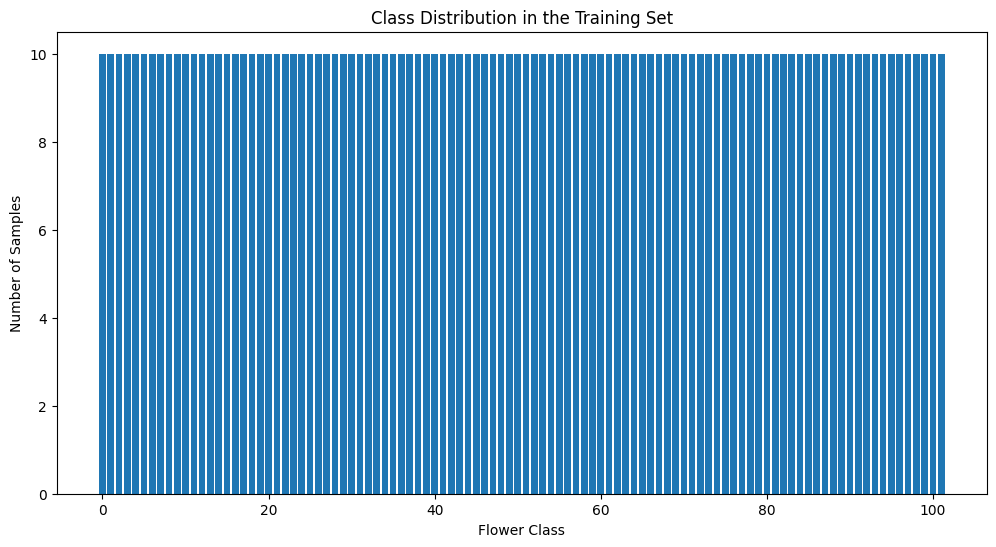

In [19]:
labels = []
for _, label in train_dataset:
    labels.append(label.numpy())

unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, counts)
plt.xlabel('Flower Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Training Set')
plt.show()

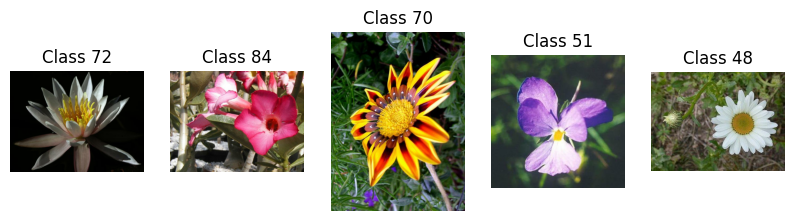

In [20]:
# Function to display random images
def plot_random_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image.numpy())
        plt.axis('off')
        plt.title(f'Class {label.numpy()}')
    plt.show()

# Display random images from the training set
plot_random_images(train_dataset)

## Preprocessing

We will resize the images to 224x224 and normalize pixel values to be between 0 and 1.

In [22]:
IMG_SIZE = 224

# Function to preprocess images
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize the image to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the pixel values to [0, 1]
    return image, label

In [23]:
train_dataset = train_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)

## Building the Model

We will use MobileNetV2 as the base model, with weights pre-trained on ImageNet. The base model will be frozen, and we will add a Global Average Pooling layer followed by a dense output layer with 102 units, corresponding to the 102 flower classes.

In [24]:
# Load model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [25]:
# Freeze the base model
base_model.trainable = False

# Build the final model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(102, activation='softmax')
])

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training the Model

Now, we will train the model for 11 epochs and monitor its performance on the validation dataset.

In [27]:
history = model.fit(
    train_dataset,
    epochs=11,
    validation_data=val_dataset
)

Epoch 1/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.0687 - loss: 4.7680 - val_accuracy: 0.4824 - val_loss: 2.5027
Epoch 2/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.7685 - loss: 1.5759 - val_accuracy: 0.6716 - val_loss: 1.6242
Epoch 3/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.9315 - loss: 0.7587 - val_accuracy: 0.7451 - val_loss: 1.2853
Epoch 4/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9765 - loss: 0.4362 - val_accuracy: 0.7667 - val_loss: 1.1167
Epoch 5/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9962 - loss: 0.2773 - val_accuracy: 0.7853 - val_loss: 1.0167
Epoch 6/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9970 - loss: 0.1884 - val_accuracy: 0.7941 - val_loss: 0.9528
Epoch 7/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9978 - loss: 0.1358 - val_accuracy: 0.7980 - val_loss: 0.9095
Epoch 8/11
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 1.0000 - loss: 0.1030 - val_accuracy: 0.8039 

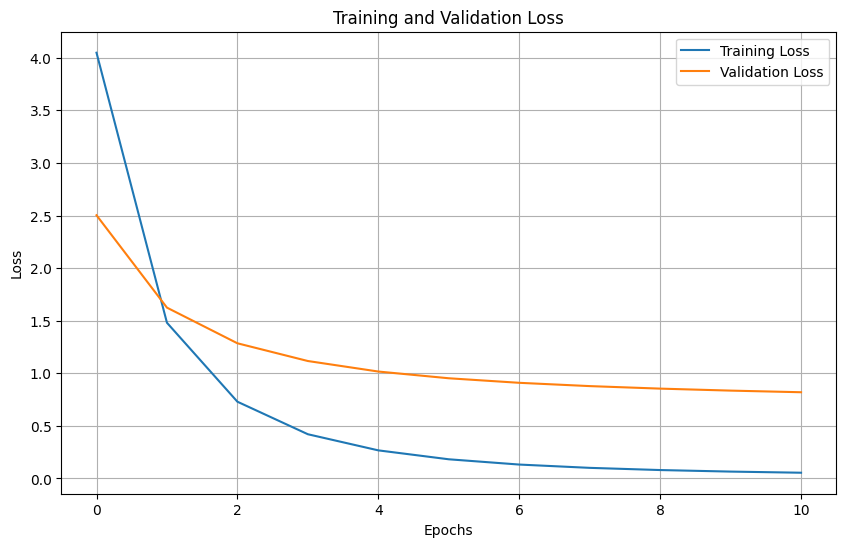

In [28]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

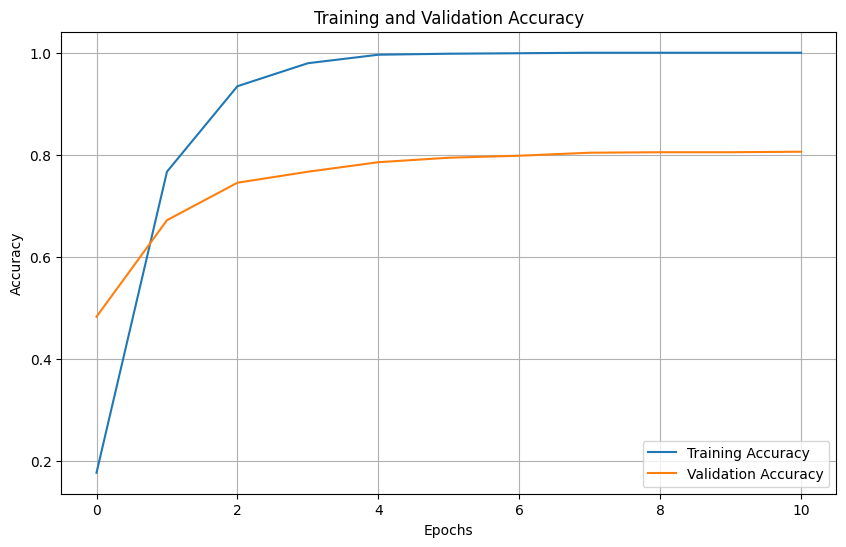

In [29]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Evaluating the Model

Finally, we will evaluate the model on the test dataset and display the accuracy.

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

385/385 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.7788 - loss: 0.9372
Test accuracy : 0.77394700050354


In this section, we will generate and visualize a confusion matrix for the flower classification model to evaluate its performance. The confusion matrix will help us understand how well the model predicts each class (flower type) and where it tends to make mistakes. We will also visualize a zoomed-in version showing only the most misclassified labels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

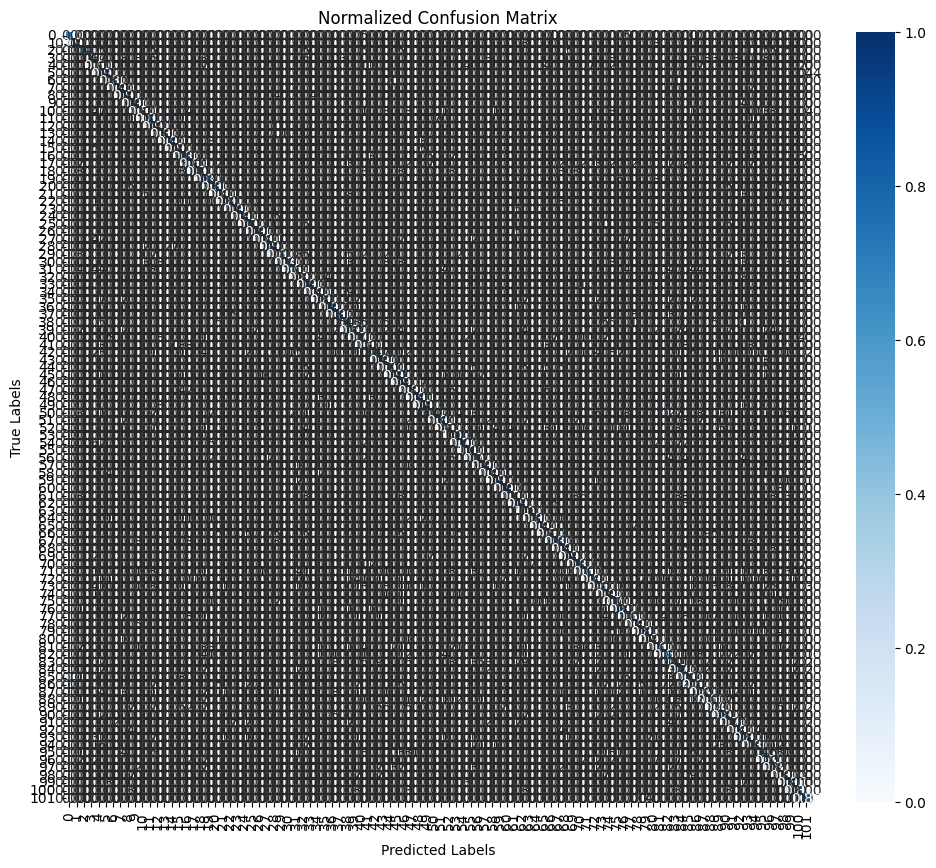

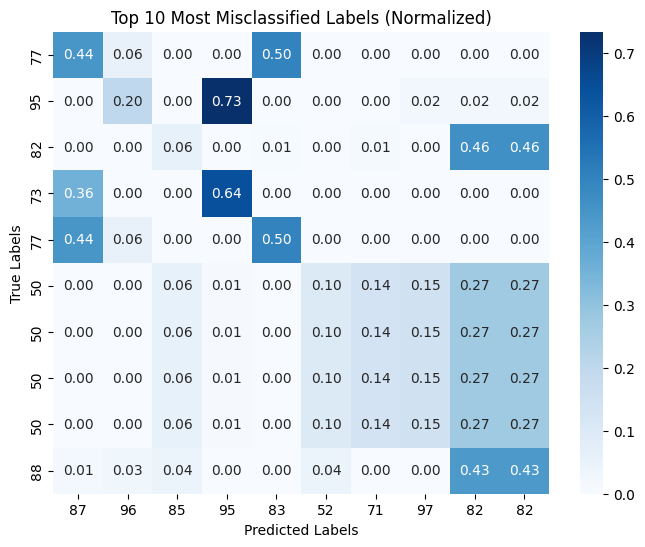

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Get true labels and predictions
true_labels = []
pred_labels = []

# Iterate through the test dataset and gather true and predicted labels
for images, labels in test_dataset:
    # Get model predictions (probabilities)
    predictions = model.predict(images)

    # Convert probabilities to class labels (by picking the class with the highest probability)
    predicted_classes = np.argmax(predictions, axis=-1)

    # Extend true and predicted labels lists
    true_labels.extend(labels.numpy())
    pred_labels.extend(predicted_classes)

# Convert true_labels to a numpy array for compatibility
true_labels = np.array(true_labels)

# Compute the confusion matrix using scikit-learn
cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))

# Normalize the confusion matrix (by rows)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the full normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Get the indices of the top 10 most misclassified classes (off-diagonal values)
misclassifications = np.abs(cm - np.diag(np.diagonal(cm)))  # Absolute values of off-diagonal elements
top_misclassified_indices = np.unravel_index(np.argsort(misclassifications.ravel())[-10:], misclassifications.shape)

# Plot confusion matrix for only the top 10 misclassified classes
cm_top10 = cm[np.ix_(top_misclassified_indices[0], top_misclassified_indices[1])]

# Normalize the confusion matrix for these top 10 classes
cm_top10_normalized = cm_top10.astype('float') / cm_top10.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_top10_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=top_misclassified_indices[1], yticklabels=top_misclassified_indices[0])
plt.title('Top 10 Most Misclassified Labels (Normalized)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Saving the Model

In [ ]:
model.save('flower_identifier_model.keras')

## Experimenting with Data Augmentation and Different Models

Below, we add data augmentation to try to improve model performance.

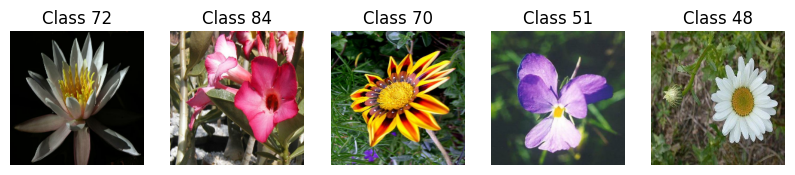

In [36]:
# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),  # Random horizontal flip
    tf.keras.layers.RandomRotation(0.2),       # Random rotation
    tf.keras.layers.RandomZoom(0.2),           # Random zoom
    tf.keras.layers.RandomTranslation(0.1, 0.1) # Random translation
])

# Function to preprocess images and apply augmentation during training
def preprocess_image(image, label, is_training=True):
    # Resize and normalize the images
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0

    # Apply data augmentation only during training
    if is_training:
        image = data_augmentation(image)

    return image, label

# Function to create original and augmented dataset
def create_combined_dataset(original_dataset, batch_size=16):
    augmented_images = original_dataset.map(lambda image, label: preprocess_image(image, label, is_training=True))
    original_images = original_dataset.map(lambda image, label: preprocess_image(image, label, is_training=False))

    # Concatenate original and augmented images
    combined_dataset = original_images.concatenate(augmented_images)
    combined_dataset = combined_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return combined_dataset

# Create the combined training dataset with original and augmented images
train_dataset = create_combined_dataset(train_dataset, batch_size=16)
val_dataset = val_dataset.map(lambda image, label: preprocess_image(image, label, is_training=False)).batch(16).prefetch(tf.data.AUTOTUNE)

# Function to visualize some images from the dataset (both original and augmented)
def plot_combined_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))

    # Loop over the dataset to get individual image batches
    for i, (image_batch, label_batch) in enumerate(dataset.take(1)):  # Only take the first batch for visualization
        for j in range(num_images):
            image = image_batch[j].numpy()  # Get the j-th image in the batch
            plt.subplot(1, num_images, j+1)  # Plot in a row of num_images
            plt.imshow(image)  # Show the image
            plt.axis('off')
            plt.title(f'Class {label_batch[j].numpy()}')

    plt.show()

# Plot some original and augmented images
plot_combined_images(train_dataset)


### MobileNetV2 with Data Augmentation

In [34]:
# Load model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [5]:
# Freeze the base model
base_model.trainable = False

# Build the final model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(102, activation='softmax')
])

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(
    train_dataset,
    epochs=11,
    validation_data=val_dataset
)

Epoch 1/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.1932 - loss: 3.9797 - val_accuracy: 0.5951 - val_loss: 1.7901
Epoch 2/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 183ms/step - accuracy: 0.8548 - loss: 0.9748 - val_accuracy: 0.7029 - val_loss: 1.2604
Epoch 3/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.9463 - loss: 0.4868 - val_accuracy: 0.7598 - val_loss: 1.0342
Epoch 4/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.9745 - loss: 0.2884 - val_accuracy: 0.7735 - val_loss: 0.9397
Epoch 5/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.9884 - loss: 0.1945 - val_accuracy: 0.7716 - val_loss: 0.8693
Epoch 6/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.9903 - loss: 0.1455 - val_accuracy: 0.7971 - val_loss: 0.8125
Epoch 7/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.9945 - loss: 0.1077 - val_accuracy: 0.8069 - val_loss: 0.7826
Epoch 8/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.9935 - loss: 0

In [8]:
test_dataset = test_dataset.map(lambda image, label: preprocess_image(image, label, is_training=False)).batch(16).prefetch(tf.data.AUTOTUNE)
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy for MobileNetv2 with data aug:', accuracy)

385/385 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.7800 - loss: 0.8971
Test accuracy for MobileNetv2 with data aug: 0.7762237787246704


### ResNet50 with Data Augmentation

In [9]:
# Load ResNet50 (you can experiment with other versions like ResNet101, ResNet152)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the final model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(102, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
history = model.fit(
    train_dataset,
    epochs=11,
    validation_data=val_dataset
)

Epoch 1/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 204ms/step - accuracy: 0.0555 - loss: 4.2872 - val_accuracy: 0.0510 - val_loss: 4.3426
Epoch 2/11
 88/128 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.0605 - loss: 4.2244

KeyboardInterrupt: 

In [12]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy for ResNet50 with data aug:', accuracy)

385/385 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.0669 - loss: 4.3723
Test accuracy for ResNet50 with data aug: 0.06537648290395737


### DenseNet121 with DataAugmentation

In [37]:
# Load DenseNet121
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the final model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(102, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
history = model.fit(
    train_dataset,
    epochs=11,
    validation_data=val_dataset
)

Epoch 1/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 89s 446ms/step - accuracy: 0.0835 - loss: 4.6105 - val_accuracy: 0.4716 - val_loss: 2.6884
Epoch 2/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.6348 - loss: 2.1437 - val_accuracy: 0.6461 - val_loss: 1.7456
Epoch 3/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 206ms/step - accuracy: 0.8411 - loss: 1.2038 - val_accuracy: 0.7284 - val_loss: 1.3425
Epoch 4/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.9100 - loss: 0.7882 - val_accuracy: 0.7637 - val_loss: 1.1345
Epoch 5/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.9388 - loss: 0.5561 - val_accuracy: 0.7814 - val_loss: 0.9962
Epoch 6/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.9624 - loss: 0.4170 - val_accuracy: 0.7863 - val_loss: 0.9274
Epoch 7/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 218ms/step - accuracy: 0.9767 - loss: 0.3272 - val_accuracy: 0.8108 - val_loss: 0.8426
Epoch 8/11
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.9789 - loss: 0

In [40]:
test_dataset = test_dataset.map(lambda image, label: preprocess_image(image, label, is_training=False)).batch(16).prefetch(tf.data.AUTOTUNE)
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy for DenseNet121 with data aug:', accuracy)

385/385 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8026 - loss: 0.8140
Test accuracy for DenseNet121 with data aug: 0.8061473369598389


Since DenseNet21 has a better test accuracy, I will use this model for the Flower Identifier application.

In [42]:
model.save('flower_identifier_densenet_model.keras')